# Stock Price Forcasting Using Tensorflow

In [24]:
import yfinance as yf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Miscellaneous Functions

In [26]:
def drop_columns(hist):
    return hist.drop(columns=['High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

def set_size(num, df):
    return df.shape[0]-num

In [27]:
## Collecting the data

In [28]:
data = yf.Ticker('MSFT')
df = drop_columns(data.history(start='2010-01-01'))
n = len(df)
df

,Open,Close
Date,,
2010-01-04,23.91,24.17
2010-01-05,24.09,24.18
2010-01-06,24.11,24.03
2010-01-07,23.92,23.78
2010-01-08,23.65,23.94
...,...,...
2020-09-17,200.05,202.91
2020-09-18,202.80,200.39
2020-09-21,197.19,202.54


In [29]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,2700.0,61.062748,47.745481,18.20,24.5750,41.57,85.2275,229.27
Close,2700.0,61.081315,47.755666,18.13,24.6075,41.65,84.8575,231.65


In [30]:
import datetime

date_time = pd.to_datetime(df.index, format='%d.%m.%Y')
timestamp_s = date_time.map(datetime.datetime.timestamp)
date_time

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2020-09-10', '2020-09-11', '2020-09-14', '2020-09-15',
               '2020-09-16', '2020-09-17', '2020-09-18', '2020-09-21',
               '2020-09-22', '2020-09-23'],
              dtype='datetime64[ns]', name='Date', length=2700, freq=None)

In [31]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices

{'Open': 0, 'Close': 1}

## Splitting the data

In [33]:
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Normalizing the data using regularization

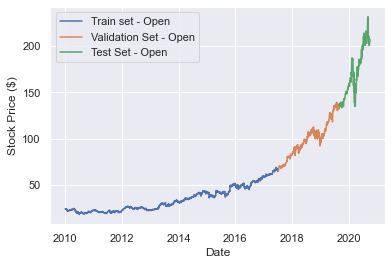

In [35]:
plt.plot(train_df['Close'])
plt.plot(val_df['Close'])
plt.plot(test_df['Close'])
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend(['Train set - Open', 'Validation Set - Open', 'Test Set - Open'])
plt.show()

In [36]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean)/train_std
val_df = (train_df - train_mean)/train_std
test_df = (train_df - train_mean)/train_std

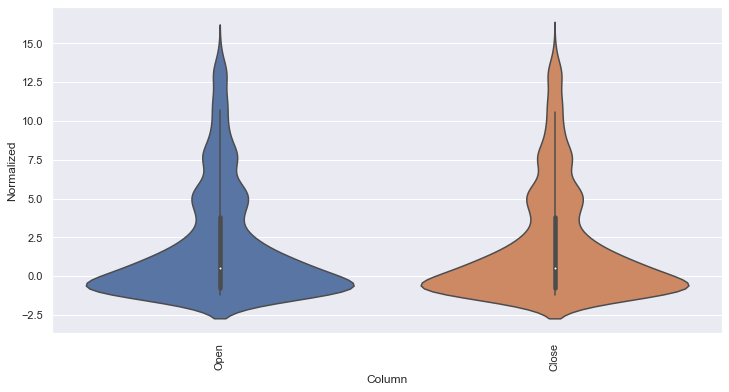

In [37]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)